In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd  /content/drive/'My Drive'/'CV Project'/
!pwd
!ls /scratch/ap6624/CV/casia2groundtruth/CASIA2.0_revised/

/home/ap6624/CV
Au  Tp	au_list.txt  tp_list.txt


In [ ]:
# import torch
# torch.cuda.is_available()

In [ ]:
# !pip install sklearn

In [2]:
import os
import datetime
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image, ImageChops, ImageEnhance
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau, ModelCheckpoint
from tqdm import tqdm


2021-12-15 18:10:22.783638: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [4]:
def get_ela(dir, filename):
    path = os.path.join(dir, filename)
    temp_img = 'tmp_img_bw.jpg'

    image = Image.open(path)
    filtered_image = image.convert('RGB').filter(ImageFilter.BoxBlur(0.5))
    filtered_image.save(temp_img, 'JPEG', quality = 90)
    
    temp_image = Image.open(temp_img)
    
    ela_image = ImageChops.difference(filtered_image, temp_image)
    
    extremas = ela_image.getextrema()
    max_ext = max([x[1] for x in extremas])
    if max_ext == 0:
        scale = 255.0
    else:
        scale = 255.0 / max_ext
    
    ela_image = ImageEnhance.Brightness(ela_image)
    ela_image = ela_image.enhance(scale)

    result = np.array(ela_image.resize((128,128))).flatten()/255

    return result

In [5]:
authentic_path = '/scratch/ap6624/CV/casia2groundtruth/CASIA2.0_revised/Au'
tampered_path = '/scratch/ap6624/CV/casia2groundtruth/CASIA2.0_revised/Tp'

X_arr = []
y_arr = []

for dir, _, files in os.walk(authentic_path):
    for filename in tqdm(files):
        if filename.endswith('jpg') or filename.endswith('png'):
            X_arr.append(get_ela(dir, filename))
            y_arr.append(0)

num_authentic = len(X_arr)
print("Authentic Images:", num_authentic)

for dir, _, files in os.walk(tampered_path):
    for filename in tqdm(files):
        if filename.endswith('jpg') or filename.endswith('png'):
            X_arr.append(get_ela(dir, filename))
            y_arr.append(1)
            
print("Tampered Images:", len(X_arr) - num_authentic)

X = np.array(X_arr)
# X = X_arr
y = y_arr

print("Shape of Train Data")
print(X.shape)

100%|██████████| 7492/7492 [01:42<00:00, 73.08it/s]


Authentic Images:
Train Size: 7437


100%|██████████| 5123/5123 [00:38<00:00, 133.49it/s]


Tampered Images:
Train+Fake Size: 9501
Shape of Train Data
(9501, 49152)


In [6]:
print(X.shape)

y = to_categorical(y, 2)
X = X.reshape(-1, 128, 128, 3)
print(X.shape)

(9501, 49152)
(9501, 128, 128, 3)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(7600, 128, 128, 3) (7600, 2)
(1901, 128, 128, 3) (1901, 2)


##Using a Basic CNN

In [12]:
from keras.applications.resnet import ResNet50

resNetCNN = Sequential()
resnet50 = ResNet50(include_top = False, pooling = 'avg', weights = 'imagenet')
resNetCNN.add(resnet50)
resNetCNN.add(Dense(256, activation = 'relu'))
resNetCNN.add(Dropout(0.1))
resNetCNN.add(Dense(128, activation='relu'))
resNetCNN.add(Dense(64, activation='relu'))
resNetCNN.add(Dropout(0.2))
resNetCNN.add(Dense(32, activation='relu'))
resNetCNN.add(Dropout(0.3))
resNetCNN.add(Dense(2, activation = 'softmax'))

for layer in resnet50.layers:
    layer.trainable = False


resNetCNN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_5 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)               

In [14]:
checkpoint_filepath = 'ResNetCNN_Detection/checkpoint'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

epochs = 10
batch_size = 32
opt = Adam(learning_rate = 0.001, decay = 0.001/epochs)

early_stopping = EarlyStopping(monitor = 'val_accuracy',min_delta = 0,patience = 2,mode = 'auto')

resNetCNN.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

2021-12-15 18:15:43.231591: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-12-15 18:15:43.231625: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-12-15 18:15:43.231764: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-12-15 18:15:43.231815: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed


In [15]:
epochs = 10
batch_size = 32

resNetCNN.fit(X_train,y_train,batch_size = batch_size,epochs = epochs,validation_data = (X_test, y_test),callbacks = [early_stopping, model_checkpoint_callback])

2021-12-15 18:15:48.770645: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-12-15 18:15:48.782490: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2900000000 Hz


Epoch 1/10
  1/238 [..............................] - ETA: 14:43 - loss: 0.7133 - accuracy: 0.6562

  2/238 [..............................] - ETA: 4:47 - loss: 0.6903 - accuracy: 0.6797 

238/238 [==============================] - 128s 1s/step - loss: 0.5583 - accuracy: 0.8774 - val_loss: 2.5174 - val_accuracy: 0.7875
Epoch 2/10
238/238 [==============================] - 179s 2s/step - loss: 0.4352 - accuracy: 0.8839 - val_loss: 2.5161 - val_accuracy: 0.7992
Epoch 3/10
238/238 [==============================] - 179s 2s/step - loss: 0.3354 - accuracy: 0.8815 - val_loss: 1.9106 - val_accuracy: 0.8018
Epoch 4/10
238/238 [==============================] - 178s 2s/step - loss: 0.2802 - accuracy: 0.8840 - val_loss: 1.7302 - val_accuracy: 0.7964
Epoch 5/10
238/238 [==============================] - 178s 2s/step - loss: 0.2416 - accuracy: 0.9042 - val_loss: 1.5106 - val_accuracy: 0.8072
Epoch 6/10
238/238 [==============================] - 179s 2s/step - loss: 0.1722 - accuracy: 0.9112 - val_loss: 1.1106 - val_accuracy: 0.8124
Epoch 7/10
238/238 [==============================] - 178s 2s/step - loss: 0.1023 - accuracy: 0.9224 - val_loss: 0.8289 - val_accuracy: 0.8272
Epoch 8/10

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           0       0.97      0.87      0.92      1481
           1       0.66      0.91      0.76       420

    accuracy                           0.88      1901
   macro avg       0.81      0.89      0.84      1901
weighted avg       0.90      0.88      0.88      1901



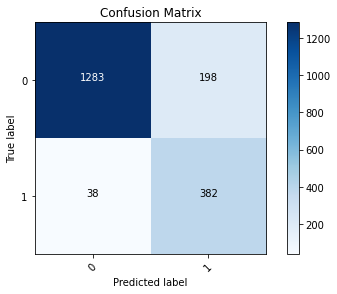

In [16]:
Y_pred = basicCNNModel.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 

cfm = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(cfm, classes = [0,1])

from sklearn.metrics import classification_report

print(classification_report(Y_true, Y_pred_classes))